In [1]:
import numpy as np # for creating probability ranges and calculating how many games needed to win a series

import math # for multiplying the probabilities of winning individual series by each other

from scipy.special import comb as choose # for nCr combination calculations

import pandas as pd # for dataframe operations

import matplotlib.pyplot as plt # for graphing results

# Simplest Model: Assume Constant Probability of Winning Each Game 

* Let's assume the probability of winning each playoff game is the same
    * And let's assume it's 50% for now

In [2]:
# single game win probability

win_probability = 0.5

* Now let's define a function which calculates the probability that an **NFL** team will win the playoffs
    * Each 'series' is just one game, so this is simply the probability of winning a single game, to the power of the number of games.
    * Division winners play 3 rounds, wild-card teams have to play 4 rounds

In [3]:
def nfl_playoffs(win_probability, wild_card = False):
    if wild_card == False:
        prob = win_probability**3
    else:
        prob = win_probability**4
    return prob

In [4]:
print(f'Wild Card Team: {nfl_playoffs(win_probability, True)}')
print(f'Non-Wild Card Team: {nfl_playoffs(win_probability)}')

Wild Card Team: 0.0625
Non-Wild Card Team: 0.125


* In this simplified model, **Wild Card** teams have a 0.0625 probability to win the championship. **Non-Wild Card** teams have a 0.125 probability of winning the championship.

### Let's compare this with the NBA

* In the NBA Playoffs, each series is best-of-7, and teams need to win 4 consecutive series to become champion
    * First, how can we calculate whether a team will win a single best-of-7 series?
        * To do this, we'll use a Negative Binomial probability.
        * With Negative Binomial (*x*, *r*, *p*) probability, we are calculating the probability that it will take us *x* trials to achieve *r* successes, with the *rth* success occurring on the *xth* trial; given *p* as the probability of success, and 1-*p* as the probability of failure on each individual trial
        
#### Let's try an example

In [5]:
def negative_binomial(x, r, p):
    prob_x = choose((x-1), (r-1)) * p**r * (1-p)**(x-r)
    return prob_x

In [6]:
negative_binomial(5, 4, win_probability)

0.125

* The above function calculated that a team with a 50% chance of winning each game would have a 0.125 probability of winning a first-to-4 series in exactly 5 games.
    * The intuition behind the equation is as follows:
        * We need the probability of 4 wins, which is the probability *p* of one win, raised to the power of 4
        * multiplied by the probability of 1 loss
        * multiplied by the number of combinations of 3 wins in the first 4 games
    * Generalized, we get the probability of *r* wins, equal to *p* to the power of *r*
    * multiplied by the probability of *x*-*r* losses, equal to (1-*p*) raised to the power of (*x* - *r*)
    * multiplied by (*x*-1) Choose (*r*-1)

#### Next, we'll calculate the probability that a team wins a best-of-x series
* To do this, we just have to identify all series-winning outcomes (win in 4, win in 5, 6, 7, etc.)
* calculate the probability of each outcome
* and add the probabilities together


In [7]:
def single_series(bestof, win_probability):
    
    # calculate wins needed by dividing max length of series by 2, then rounding up
    wins_needed = np.ceil((bestof/2))
    
    # Create a list of probabilities corresponding to all series-winning outcomes
    sum_list = []
    for i in np.arange(wins_needed, (bestof+1)):
        sum_list.append(negative_binomial(i, wins_needed, win_probability))
    # Add probabilities together
    total_prob = np.sum(sum_list)
    return total_prob
    

#### We can see that a team with a 50% probability of winning each game has a 50% chance of winning a 7 game series. This makes sense!

In [8]:
single_series(7, win_probability)

0.5

#### Now let's define a function that calculates the probability that a team wins the entire playoffs

* All we have to do is calculate the probability of winning each series
* and multiply those probabilities together
* We'll give the user the option to set different series lengths, so that we can model different playoff formats - so technically, we could model the NFL playoffs using this function too.

In [9]:
def nba_playoffs(win_probability, customize = False):
    # default assumes 4 series, each best-of-7
    if customize == False:
        prob = single_series(7, win_probability)**4
        return prob
    else:
    # Alternatively, the series lengths can be entered as comma-separated lists
        series_list = input('Enter comma-separated list of series lengths (max_games): ')
    # The following code parses integer lengths from the inputted string,  
    # and creates a new list of the probabilities of winning each individual series

        new_list = series_list.split(sep=',')


        mult_list = []
        for i in new_list:
            single = single_series(int(i), win_probability)
            mult_list.append(single)
            
    # now we just have to multiply the probabilities together

        prob = math.prod(mult_list)
        return prob

### To this point, we've been using a single game win probability of 50%. But what if we want to calculate based on a different single game win probability?
* We could change the ```win_probability``` variable
* Or we could calculate based on a range of possible variables, which would allow us to analyze how changes in the probability of winning each game affects the likelihood of winning the entire playoffs.

In [10]:
# create a Series (dataframe column) comprised of a range from 0.01 to 0.99
win_prob_range = pd.Series(np.arange(0.01, 1, 0.01))

In [11]:
# create a dataframe of the probability of winning the playoffs,
# given single game win probability, for NBA and NFL teams (Wildcard/No Wildcard)
winprob_df = pd.DataFrame({'Prob(Single Game)': win_prob_range})

winprob_df['NFL WildCard'] = nfl_playoffs(winprob_df['Prob(Single Game)'], True)

winprob_df['NFL No WC'] = nfl_playoffs(winprob_df['Prob(Single Game)'])

winprob_df['NBA'] = 0

for i in winprob_df.index:
    winprob_df['NBA'].loc[i] = nba_playoffs(winprob_df['Prob(Single Game)'][i])

C:\Users\Wally\anaconda3\envs\WebScrape\lib\site-packages\pandas\core\indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


### Plotting the data

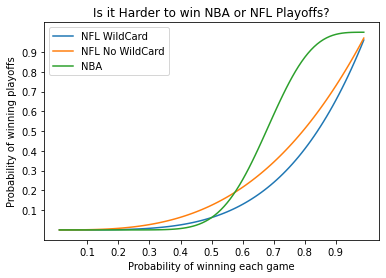

In [12]:
%matplotlib inline
plt.plot(winprob_df['Prob(Single Game)'], winprob_df['NFL WildCard'], label='NFL WildCard')
plt.plot(winprob_df['Prob(Single Game)'], winprob_df['NFL No WC'], label='NFL No WildCard')
plt.plot(winprob_df['Prob(Single Game)'], winprob_df['NBA'], label='NBA')
plt.title('Is it Harder to win NBA or NFL Playoffs?')
plt.xlabel('Probability of winning each game')
plt.ylabel('Probability of winning playoffs')
plt.xticks(np.arange(0.1, 1, 0.1))
plt.yticks(np.arange(0.1, 1, 0.1))
plt.legend()
plt.show()

### That's a pretty interesting visualization

* NFL teams see their chances of winning the playoffs increase exponentially as their probability of winning each game increases. For NBA teams, the corresponding increase follows more of a sigmoid function (think logistic regression)
* The likelihood of an NBA team winning 4 consecutive series, given a 50% chance of winning each game, is 6.25%, identical to that of an NFL team winning 4 consecutive games (Wild Card through Super Bowl) given the same 50% chance of winning each game.
* Underdogs - teams with less than 50% chance of winning each individual game - are more likely to go all the way in the NFL playoffs than in the NBA playoffs. It is easier to beat the odds over 4 consecutive games, than over 4 consecutive 7 game series.
* By the same token, favorites - teams with greater than 50% chance of winning each individual game - are more likely to win the NBA Finals than the Super Bowl.
* This analysis we've done so far does a good job describing how the different playoff formats for the NBA and NFL affect championship probabilities, independently of team/opponent quality (expressed by probability of winning each single game)
* However, what if we don't think that a constant probability of winning each game is realistic? 
* Let's allow for changing win probabilities 

#### Let's define a function ```playoffs_2```, which allows users to input the single-game win probability for each series
* Playoff opponents tend to get progressively better, and our calculations should reflect that
    * For example, you could have 4 best-of-7 series, where the probability of winning each game is 0.75 for the first series, and 0.5 subsequently

In [13]:
def playoffs_2(customize = True, win_probability=win_probability):
    # If no parameters passed, this is simply nba_playoffs(win_probability)
    if customize == False:
        prob = single_series(7, win_probability)**4
        return prob
    else:
    # Alternatively, the series lengths can be entered as comma-separated lists
        series_list = input('Enter comma-separated list of series lengths (max games): ')
    # The single-game win probabilities for each series can be entered similarly
        win_prob_list = input('Enter comma-separated list of single-game win prob for each series: ')
    # The following code parses integer lengths from the inputted strings,  
        new_list = series_list.split(sep=',')
        new_prob_list = win_prob_list.split(sep=',')
    # This loop creates a list of probabilities to win each series

        mult_list = []
        count = 0
        for i in new_list:
            single = single_series(int(new_list[count]), float(new_prob_list[count]))
            mult_list.append(single)
            count += 1
            
    # now we just have to multiply the probabilities together

        prob = math.prod(mult_list)
        return prob

#### Let's do some more NBA/NFL comparisons

* Let's say single-game win probability decreases from 0.75 in the first round, to 0.5 in all rounds thereafter.
    * We can compare the probability of winning all four rounds if they are 7 game series (NBA), or 1 game series (NFL)

In [14]:
# NBA
playoffs_2(True)

Enter comma-separated list of series lengths (max games):  7,7,7,7
Enter comma-separated list of single-game win prob for each series:  .75,.5,.5,.5


0.116180419921875

In [15]:
# NFL
playoffs_2(True)

Enter comma-separated list of series lengths (max games):  1,1,1,1
Enter comma-separated list of single-game win prob for each series:  .75,.5,.5,.5


0.09375

#### In this scenario, the NBA team is more likely than the NFL team to win their respective playoffs.
* This makes sense! Earlier we noted how favorites (above 0.5 single game win probability) were better off in the NBA format than in the NFL format
    * The NBA team in this scenario is therefore likelier than the NFL team to advance past the first round, while being equally likely to win the subsequent rounds

### Let's make one final calculator function, ```playoffs_3```

* What if we know that we want single-game win probability to increase or decrease with each round, but we don't want to manually enter each round's corresponding probability?
    * This function allows users to set a single-game win probability for the first round, as well as one for the final round. 
    * With each round, the single-game win probability will trend toward the final round probability, either linearly or exponentially

In [16]:
def playoffs_3(start_prob, end_prob, chng_function='linear'):
    # The series lengths are entered as a comma-separated list
    series_list = input('Enter comma-separated list of series lengths (max games): ')
    # The following code parses integer lengths from the inputted strin  
    new_list = series_list.split(sep=',')
    
    # This variable represents the number of times the single-game win probability will change
    chng_count = -1
    for i in new_list:
        chng_count += 1
    
    # An empty list, which will be populated by the win probabilities of each round  
    win_prob_list = []
    
    
    if chng_function == 'linear':
        
        # calculate the linear change in probability for each increment
        diff = end_prob - start_prob
        delta = diff/chng_count
        
        prob = start_prob
        
        # populate the win probability list
        empty_count = 0
        while empty_count <= chng_count:
            win_prob_list.append(prob)
            prob = prob + delta
            empty_count += 1
        
        # create a list comprised of probabilities to win each series
        mult_list = []
        count = 0
        for i in new_list:
            single = single_series(int(new_list[count]), float(win_prob_list[count]))
            mult_list.append(single)
            count += 1

        # now we just have to multiply the probabilities together

        final_prob = math.prod(mult_list)
            
        return final_prob
    
    elif chng_function == 'exponential':
        
        # calculates the percentage change for each increment
        change = (end_prob/start_prob)**(1/chng_count)
       
        prob = start_prob
        # populate the win probability list
        empty_count = 0
        while empty_count <= chng_count:
            win_prob_list.append(prob)
            prob = prob*change
            empty_count += 1
       
        # create a list comprised of probabilities to win each series    
        mult_list = []
        count = 0
        for i in new_list:
            single = single_series(int(new_list[count]), float(win_prob_list[count]))
            mult_list.append(single)
            count += 1

        # now we just have to multiply the probabilities together

        final_prob = math.prod(mult_list)
            
        return final_prob
    

#### Let's make a couple final comparisons
* First, we'll look at a 'contender', who are heavy favorites in the first round, and a tossup in the final round

In [17]:
# NBA format, single game win prob decreasing linearly from 0.8 to 0.5
playoffs_3(start_prob=0.8, end_prob=0.5, chng_function='linear')

Enter comma-separated list of series lengths (max games):  7,7,7,7


0.2999998648009361

In [18]:
# NBA format, single game win prob decreasing exponentially from 0.8 to 0.5
playoffs_3(start_prob=0.8, end_prob=0.5, chng_function='exponential')

Enter comma-separated list of series lengths (max games):  7,7,7,7


0.2802160867809368

In [19]:
# NFL format, single game win prob decreasing linearly from 0.8 to 0.5
playoffs_3(start_prob=0.8, end_prob=0.5, chng_function='linear')

Enter comma-separated list of series lengths (max games):  1,1,1,1


0.16800000000000007

In [20]:
# NFL format, single game win prob decreasing exponentially from 0.8 to 0.5

playoffs_3(start_prob=0.8, end_prob=0.5, chng_function='exponential')

Enter comma-separated list of series lengths (max games):  1,1,1,1


0.16000000000000011

* Now let's look at a dark horse, favored slightly in the first round, and an underdog in the finals

In [21]:
# NBA format, single game win prob decreasing linearly from 0.6 to 0.3
playoffs_3(start_prob=0.6, end_prob=0.3, chng_function='linear')

Enter comma-separated list of series lengths (max games):  7,7,7,7


0.012969898221109255

In [22]:
# NBA format, single game win prob decreasing exponentially from 0.6 to 0.3
playoffs_3(start_prob=0.6, end_prob=0.3, chng_function='exponential')

Enter comma-separated list of series lengths (max games):  7,7,7,7


0.009963811100117136

In [23]:
# NFL format, single game win prob decreasing linearly from 0.6 to 0.3
playoffs_3(start_prob=0.6, end_prob=0.3, chng_function='linear')

Enter comma-separated list of series lengths (max games):  1,1,1,1


0.036000000000000004

In [24]:
# NFL format, single game win prob decreasing linearly from 0.6 to 0.3
playoffs_3(start_prob=0.6, end_prob=0.3, chng_function='exponential')

Enter comma-separated list of series lengths (max games):  1,1,1,1


0.032400000000000005

# Feel free to try your own combinations!

* Try calculating probabilities for March Madness, or the MLB Playoffs, etc.